# Preprocessing
Dataset preprocessing and a simple logistic regression baseline implementation

In [40]:
import html
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from jupyterthemes import jtplot
from podium.preproc.lemmatizer.croatian_lemmatizer import (
    CroatianLemmatizer, get_croatian_lemmatizer_hook)
from podium.preproc.stop_words import CROATIAN_EXTENDED
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import metrics
from hina_loader import load_full_hina_dataset
from utils import flatten_dataset

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

nltk.download('punkt')
jtplot.style()

[nltk_data] Downloading package punkt to /home/ianic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset = load_full_hina_dataset(
    '/home/ianic/ma_thesis/hina/TreningSet-HINA-200901 - 40023 documents.xml')
print(len(dataset))

In [3]:
dataset = flatten_dataset(dataset, 2)
print(len(dataset))

39110


In [4]:
df = pd.DataFrame(dataset, columns=['text', 'topics', 'genre'])
# remove articles with no topics
df_new = df[~(df['topics'].str.len() == 0)]

df = df_new
df.reset_index(drop=True, inplace=True)

# convert to k-hot encoded
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df['topics']),
                          columns=mlb.classes_,
                          index=df.index))

## Remove labels with low occurrency count (< 20)

In [5]:
# set to see more rows
# pd.set_option("display.max_rows", 1223)
len(list(df.columns.values))

217

In [6]:
topics = list(df.columns.values[5:])
topics_df = pd.DataFrame(
    {'topics': list(topics), 'count': list(df.iloc[:, 5:].sum().values)})

# selecting top n most frequent topics
topn = None
if topn is not None:
    _df = topics_df.nlargest(columns="count", n=topn)
else:
    _df = topics_df
topics_df

,topics,count
0,DRUŠTVO|DONACIJE,201
1,DRUŠTVO|HUMANITARNI RAD,216
2,DRUŠTVO|INVALIDI,198
3,DRUŠTVO|LJUDSKA PRAVA,550
4,DRUŠTVO|NAGRADE I PRIZNANJA,577
...,...,...
207,ZNANOSTI I TEHNOLOGIJA|STANDARDI,23
208,ZNANOSTI I TEHNOLOGIJA|TEHNIČKE ZNANOSTI,416
209,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENA ISTRAŽIVANJA,145
210,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENE USTANOVE I ORGANIZACIJE,131


In [7]:
top_n_cats = list(_df.iloc[:, 0])
c = df[top_n_cats]

print(f"top n categories: {c.shape}")

y_m = topics_df[(topics_df['count'] < 10)]
print(y_m.shape)
y_m

top n categories: (39077, 212)
(19, 2)


,topics,count
32,KULTURA I UMJETNOST|FILATELIJA,5
55,KULTURA I UMJETNOST|POPULARNA KULTURA,1
86,POLITIKA,1
103,PRAVOSUĐE/SUDSTVO/KRIMINAL,1
127,RELIGIJA I VJEROVANJE,3
128,RELIGIJA I VJEROVANJE|ATEIZAM,9
139,SPORT|BADMINTON,3
140,SPORT|BASEBALL,3
142,SPORT|BILJAR,1
144,SPORT|BOĆANJE,2


In [8]:
mask = df.index.isin(y_m.index.values)
mask

array([False, False, False, ..., False, False, False])

In [9]:
print(df.shape)
old_size = df.shape[0]
old_size

(39077, 217)


39077

In [10]:
df = df.loc[~mask]

In [11]:
# ensure good filtering
assert old_size - df.shape[0] == y_m.shape[0]

In [12]:
# ensure good napping
print(dataset[0].topics)

assert 1 == df.loc[0, 'ZDRAVLJE|ZDRAVSTVO/ZDRAVSTVENI SUSTAV']

{'ZDRAVLJE|ZDRAVSTVO/ZDRAVSTVENI SUSTAV', 'PRAVOSUĐE/SUDSTVO/KRIMINAL|KAZNE', 'PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL', 'PRAVOSUĐE/SUDSTVO/KRIMINAL|PRAVOSUĐE'}


In [13]:
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame(
        {'word': list(fdist.keys()), 'count': list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(15, terms / 5))
    ax = sns.barplot(data=d, x="count", y="word", color='lightseagreen')
    ax.set(ylabel='Word')

    plt.show()
    return words_df.shape[0]


def all_words(x):
    words = ' '.join([text for text in x])
    words = words.split()
    return list(set(words))

## Preprocessing

In [14]:
# function for text cleaning
# variant 1: all single digits
# variant 2: all numbers
# variant 3: with single letters removed
# variant 4: parameter in lr disbalance

def replace_num_token(text, replace_with=' '):
    text = re.sub(r"\d+", replace_with, text).strip()
    return text


stop_words = set(CROATIAN_EXTENDED)


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [15]:
print(replace_num_token("3ovo 33 j3 3 t3kst i 3 5."))
print(replace_num_token("3"))

ovo   j    t kst i    .



In [16]:
lemmatizer = CroatianLemmatizer()
# function for text cleaning


def clean_text(text):

    # split on change case lower-upper
    # maybe add upper-lower, but only when 2+ chars preceed
    # otherwise, Hrvatska would be split to h rvatska
    groups = re.sub(r'(?<=[a-z])(?=[A-Z])', '~', text).split('~')

    text = ' '.join(groups)

    # lowercase
    text = text.lower()

    # strip html tags
    text = html.unescape(text)

    # remove non-words
    text = re.sub('\W', ' ', text)

    # remove single chars
    text = re.sub(r'(?:^| )\w(?:$| )', ' ', text)

    # remove/replace numbers
    text = replace_num_token(text)

    # tokenize, lemmatize, remove stopwords
    tokenized = nltk.word_tokenize(text)
    tokenized = list(map(lambda x: lemmatizer.lemmatize_word(x), tokenized))
    tokenized = list(map(lambda x: remove_stopwords(x), tokenized))
    tokenized = list(filter(lambda x:  x != '', tokenized))

    return tokenized

In [17]:
text = "splitOVO JEsplit Hrvatska SPLIT split bananaSPLITsplit SPLITbananaSPLIT"
print(text)
print(clean_text(text))

splitOVO JEsplit Hrvatska SPLIT split bananaSPLITsplit SPLITbananaSPLIT
['split', 'jesplit', 'hrvatski', 'split', 'split', 'banana', 'splitsplit', 'splitbanana', 'split']


In [19]:
text = "&ltMEĐUNARODNA&gt KONFERENCIJA <b> &lt&lt O KLASTERIMAPOTICAJ" + \
    "\tf konkurentnosti ukupne privredeU sklopu programa Hrvatska "
print(text)
print(clean_text(text))

&ltMEĐUNARODNA&gt KONFERENCIJA <b> &lt&lt O KLASTERIMAPOTICAJ	f konkurentnosti ukupne privredeU sklopu programa Hrvatska 
['međunarodan', 'konferencija', 'klasterimapoticaj', 'konkurentnost', 'ukupan', 'privrediti', 'sklop', 'program', 'hrvatski']


In [20]:
clean_text_tokenized = df['text'].apply(lambda x: clean_text(x))
clean_text = clean_text_tokenized.apply(lambda x: " ".join(x))

In [21]:
df.insert(0, 'clean_text_tokenized', clean_text_tokenized)
df.insert(0, 'clean_text', clean_text)

df['id'] = df.index
df.set_index("id", inplace=True)

df

,clean_text,clean_text_tokenized,text,topics,genre,DRUŠTVO,DRUŠTVO|DEMOGRAFIJA,DRUŠTVO|DONACIJE,DRUŠTVO|HUMANITARNI RAD,DRUŠTVO|INVALIDI,...,ZNANOSTI I TEHNOLOGIJA|BIOMEDICINA I ZDRAVSTVO,ZNANOSTI I TEHNOLOGIJA|BIOTEHNIČKE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|DRUŠTVENE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|HUMANISTIČKE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|PRIRODNE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|STANDARDI,ZNANOSTI I TEHNOLOGIJA|TEHNIČKE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENA ISTRAŽIVANJA,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENE USTANOVE I ORGANIZACIJE,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENI DJELATNICI
id,,,,,,,,,,,,,,,,,,,,,
0,pravdati čekanje sedati godina smrt tan kasum znati krivac optužen liječnik raditi obitelj pokojnica ček suđenje split sedati godina smrt nesretan tan kasum kriviti dijagnoza utvrđen odgovornost liječnik splitski bolnica optužnica ček red sazivanje suđenje godina mjesec općinski sud split zaprim...,"[pravdati, čekanje, sedati, godina, smrt, tan, kasum, znati, krivac, optužen, liječnik, raditi, obitelj, pokojnica, ček, suđenje, split, sedati, godina, smrt, nesretan, tan, kasum, kriviti, dijagnoza, utvrđen, odgovornost, liječnik, splitski, bolnica, optužnica, ček, red, sazivanje, suđenje, god...",PRAVDA NA ČEKANJU SEDAM GODINA NAKON SMRTI TANJE KASUM (26) JOŠ UVIJEK SE NE ZNAJU KRIVCI\t Optuženi liječnici rade dok obitelj pokojnice čeka suđenjeSPLIT • Sedam godina nakon smrti nesretne Tanje Kasum (26) zbog krive dijagnoze još uvijek nije utvrđena odgovornost liječnika splitske bolnice. O...,"{ZDRAVLJE|ZDRAVSTVO/ZDRAVSTVENI SUSTAV, PRAVOSUĐE/SUDSTVO/KRIMINAL|KAZNE, PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL, PRAVOSUĐE/SUDSTVO/KRIMINAL|PRAVOSUĐE}",Izvještaj,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,uhvaćen okorjeo kriminalac presresti djevojčica zaprijetiti nož ugurati automobil vesti lisica volan djevojčica iskoristiti prometan nesreća pobjeći otmičar evidentiran kaznen djelo međa ostao silovanje pokušaj ubojstvo rijeka star policijski znanac vrbovski uhićen ponedjeljak rijeka prijetiti n...,"[uhvaćen, okorjeo, kriminalac, presresti, djevojčica, zaprijetiti, nož, ugurati, automobil, vesti, lisica, volan, djevojčica, iskoristiti, prometan, nesreća, pobjeći, otmičar, evidentiran, kaznen, djelo, međa, ostao, silovanje, pokušaj, ubojstvo, rijeka, star, policijski, znanac, vrbovski, uhiće...","UHVAĆEN Okorjeli kriminalac presreo je djevojčicu, zaprijetio joj nožem, ugurao u automobil i vezao ju lisicama za volan Djevojčica iskoristila prometnu nesreću i pobjegla otmičaruS. A. je evidentiran zbog više od 40 kaznenih djela, među ostalim i zbog dva silovanja i pokušaja ubojstvaRIJEKA - S...","{PRAVOSUĐE/SUDSTVO/KRIMINAL|POLICIJA, PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL}",Izvještaj,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,međunarodan konferencija klasterimapoticaj konkurentnost ukupan privrediti sklop program hrvatski izvozan ofenziva predviđati osnivanje uspostava nov klastera jedini cilj izvoz hrvatski sklop županija poslovati ukupan klastera udružen tvrtka zapošljavati ukupan djelatnik sklop program hrvatski i...,"[međunarodan, konferencija, klasterimapoticaj, konkurentnost, ukupan, privrediti, sklop, program, hrvatski, izvozan, ofenziva, predviđati, osnivanje, uspostava, nov, klastera, jedini, cilj, izvoz, hrvatski, sklop, županija, poslovati, ukupan, klastera, udružen, tvrtka, zapošljavati, ukupan, djel...",MEĐUNARODNA KONFERENCIJA O KLASTERIMAPOTICAJ konkurentnosti ukupne privredeU sklopu programa Hrvatska izvozna ofenziva predviđa se osnivanje i uspostava pet novih klastera kojima će jedini cilj biti izvozU Hrvatskoj danas u sklopu osam županija posluju ukupno 22 klastera u koje je udruženo 398 t...,"{GOSPODARSTVO/POSLOVANJE/FINANCIJE|EKONOMIJA OPĆENITO, GOSPODARSTVO/POSLOVANJE/FINANCIJE|GOSPODARSKO POSLOVANJE, POLITIKA|MEĐUNARODNI POLITIČKI ODNOSI, GOSPODARSTVO/POSLOVANJE/FINANCIJE|MAKROEKONOMIJA}",Izvještaj,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,split otvoren izložba hrvatski novinski fotografija premijer hrvatski fotografski izvrsnost žir odabrati ponuđen

#### preprocessed text

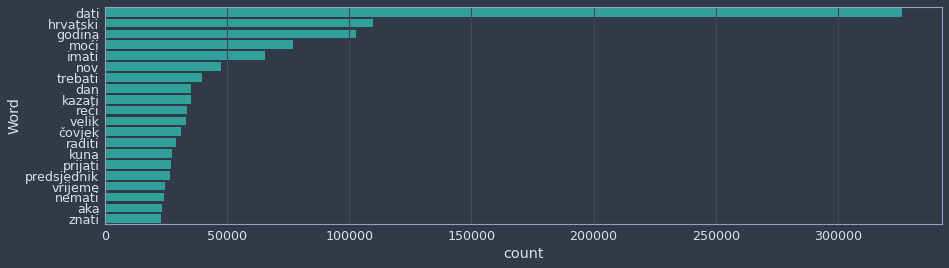

361273


In [22]:
# print 20 most frequent words
size = freq_words(df['clean_text'], 20)
print(size)

#### unprocessed text

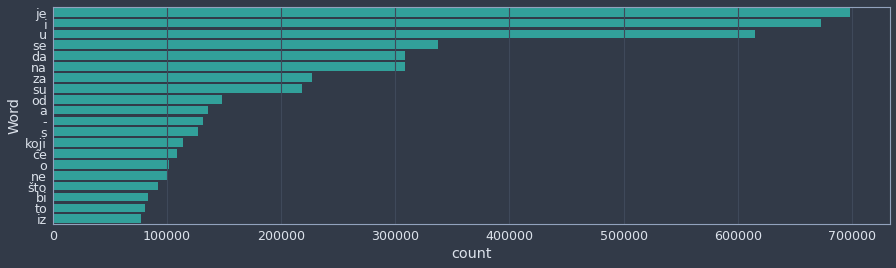

1377714


In [23]:
size = freq_words(df['text'], 20)
print(size)

## Save and verify

In [17]:
df.to_pickle("./dataset_2_with_topics_prot_4.pkl")

In [26]:
unpickled_df = pd.read_pickle("./dataset_2_with_topics_prot_4.pkl")
unpickled_df

,clean_text,clean_text_tokenized,text,topics,genre,DRUŠTVO,DRUŠTVO|DEMOGRAFIJA,DRUŠTVO|DONACIJE,DRUŠTVO|HUMANITARNI RAD,DRUŠTVO|INVALIDI,...,ZNANOSTI I TEHNOLOGIJA|BIOMEDICINA I ZDRAVSTVO,ZNANOSTI I TEHNOLOGIJA|BIOTEHNIČKE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|DRUŠTVENE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|HUMANISTIČKE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|PRIRODNE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|STANDARDI,ZNANOSTI I TEHNOLOGIJA|TEHNIČKE ZNANOSTI,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENA ISTRAŽIVANJA,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENE USTANOVE I ORGANIZACIJE,ZNANOSTI I TEHNOLOGIJA|ZNANSTVENI DJELATNICI
id,,,,,,,,,,,,,,,,,,,,,
0,pravdati čekanje sedati godina smrt tan kasum znati krivac optužen liječnik raditi obitelj pokojnica ček suđenje split sedati godina smrt nesretan tan kasum kriviti dijagnoza utvrđen odgovornost liječnik splitski bolnica optužnica ček red sazivanje suđenje godina mjesec općinski sud split zaprim...,"[pravdati, čekanje, sedati, godina, smrt, tan, kasum, znati, krivac, optužen, liječnik, raditi, obitelj, pokojnica, ček, suđenje, split, sedati, godina, smrt, nesretan, tan, kasum, kriviti, dijagnoza, utvrđen, odgovornost, liječnik, splitski, bolnica, optužnica, ček, red, sazivanje, suđenje, god...",PRAVDA NA ČEKANJU SEDAM GODINA NAKON SMRTI TANJE KASUM (26) JOŠ UVIJEK SE NE ZNAJU KRIVCI\t Optuženi liječnici rade dok obitelj pokojnice čeka suđenjeSPLIT • Sedam godina nakon smrti nesretne Tanje Kasum (26) zbog krive dijagnoze još uvijek nije utvrđena odgovornost liječnika splitske bolnice. O...,"{ZDRAVLJE|ZDRAVSTVO/ZDRAVSTVENI SUSTAV, PRAVOSUĐE/SUDSTVO/KRIMINAL|KAZNE, PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL, PRAVOSUĐE/SUDSTVO/KRIMINAL|PRAVOSUĐE}",Izvještaj,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,uhvaćen okorjeo kriminalac presresti djevojčica zaprijetiti nož ugurati automobil vesti lisica volan djevojčica iskoristiti prometan nesreća pobjeći otmičar evidentiran kaznen djelo međa ostao silovanje pokušaj ubojstvo rijeka star policijski znanac vrbovski uhićen ponedjeljak rijeka prijetiti n...,"[uhvaćen, okorjeo, kriminalac, presresti, djevojčica, zaprijetiti, nož, ugurati, automobil, vesti, lisica, volan, djevojčica, iskoristiti, prometan, nesreća, pobjeći, otmičar, evidentiran, kaznen, djelo, međa, ostao, silovanje, pokušaj, ubojstvo, rijeka, star, policijski, znanac, vrbovski, uhiće...","UHVAĆEN Okorjeli kriminalac presreo je djevojčicu, zaprijetio joj nožem, ugurao u automobil i vezao ju lisicama za volan Djevojčica iskoristila prometnu nesreću i pobjegla otmičaruS. A. je evidentiran zbog više od 40 kaznenih djela, među ostalim i zbog dva silovanja i pokušaja ubojstvaRIJEKA - S...","{PRAVOSUĐE/SUDSTVO/KRIMINAL|POLICIJA, PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL}",Izvještaj,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,međunarodan konferencija klasterimapoticaj konkurentnost ukupan privrediti sklop program hrvatski izvozan ofenziva predviđati osnivanje uspostava nov klastera jedini cilj izvoz hrvatski sklop županija poslovati ukupan klastera udružen tvrtka zapošljavati ukupan djelatnik sklop program hrvatski i...,"[međunarodan, konferencija, klasterimapoticaj, konkurentnost, ukupan, privrediti, sklop, program, hrvatski, izvozan, ofenziva, predviđati, osnivanje, uspostava, nov, klastera, jedini, cilj, izvoz, hrvatski, sklop, županija, poslovati, ukupan, klastera, udružen, tvrtka, zapošljavati, ukupan, djel...",MEĐUNARODNA KONFERENCIJA O KLASTERIMAPOTICAJ konkurentnosti ukupne privredeU sklopu programa Hrvatska izvozna ofenziva predviđa se osnivanje i uspostava pet novih klastera kojima će jedini cilj biti izvozU Hrvatskoj danas u sklopu osam županija posluju ukupno 22 klastera u koje je udruženo 398 t...,"{GOSPODARSTVO/POSLOVANJE/FINANCIJE|EKONOMIJA OPĆENITO, GOSPODARSTVO/POSLOVANJE/FINANCIJE|GOSPODARSKO POSLOVANJE, POLITIKA|MEĐUNARODNI POLITIČKI ODNOSI, GOSPODARSTVO/POSLOVANJE/FINANCIJE|MAKROEKONOMIJA}",Izvještaj,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,split otvoren izložba hrvatski novinski fotografija premijer hrvatski fotografski izvrsnost žir odabrati ponuđen

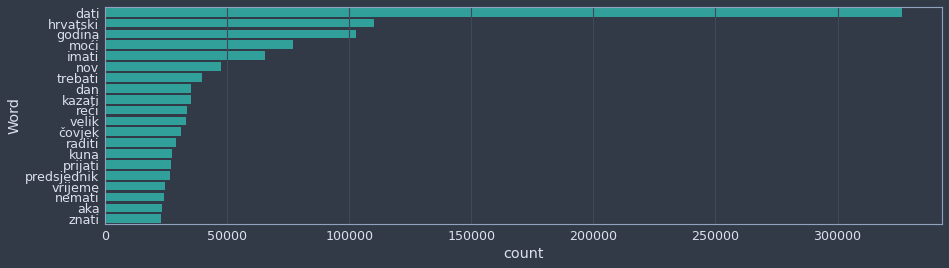

361363

In [27]:
freq_words(unpickled_df['clean_text'], 20)

## Baseline
A simple, naïve baseline implementation. Naïve here means that the model treats classes as mutually independent; no knowledge about the underlying hierarchical relations is implemented here.

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(
    unpickled_df['clean_text'], unpickled_df.iloc[:, 5:], test_size=0.2, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(
    xtrain, ytrain, test_size=0.25, random_state=42)

In [30]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
xtest_tfidf = tfidf_vectorizer.transform(xtest)
print(xtrain_tfidf.shape, xval_tfidf.shape, xtest_tfidf.shape)

(23445, 10000) (7816, 10000) (7816, 10000)


In [31]:
from sklearn.multiclass import OneVsRestClassifier

lr = LogisticRegression(class_weight="balanced", multi_class="multinomial")
clf = OneVsRestClassifier(lr)

In [32]:
clf.fit(xtrain_tfidf, ytrain.to_numpy())

/home/ianic/.conda/envs/dipl/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 0 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/ianic/.conda/envs/dipl/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 57 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/ianic/.conda/envs/dipl/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 88 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/home/ianic/.conda/envs/dipl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the do

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='multinomial',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [33]:
y_pred_prob = clf.predict_proba(xval_tfidf)
y_pred = clf.predict(xval_tfidf)

In [34]:
topics = list(yval)
print(len(topics))
print(topics[213])

214
ZNANOSTI I TEHNOLOGIJA|ZNANSTVENI DJELATNICI


In [42]:
def get_true_pred(labels, threshold=0.5):
    lab = (y_pred_prob >= threshold).astype(int)

    def onehot_to_ind(l):
        return [index for index, value in enumerate(l) if value == 1]

    indices = list(map(onehot_to_ind, lab))
    indices_true = list(map(onehot_to_ind, yval.to_numpy()))

    labels_pred = list(map(lambda x: [labels[y] for y in x], indices))
    labels_true = list(map(lambda x: [labels[y] for y in x], indices_true))

    return labels_true, labels_pred

In [43]:
labels_true, labels_pred = get_true_pred(topics, 0.6)

(7816, 214)
(7816, 214)
7816
7816
7816
['PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL', 'ZDRAVLJE|MEDICINSKO OSOBLJE', 'ZNANOSTI I TEHNOLOGIJA|ZNANSTVENI DJELATNICI']


In [36]:
# now here
import pickle
ch = None
with open('ch.pickle', 'rb') as f:
    _ch = pickle.load(f)
    # print(_ch)
    ch = _ch

In [44]:
metrics.classification_report(ch, labels_true, labels_pred)

=PRECISION==================================================
precision_anc : 0.6098494819210797
precision_desc: 0.5395161844546766
precision_brnc: 0.6082749572429305
=RECALL==================================================
recall_anc : 0.7663048380792014
recall_desc: 0.7282129771346413
recall_brnc: 0.7605976270689908
=F1==================================================
f1_score_anc : 0.6791834341603816
f1_score_desc: 0.6198211712689734
f1_score_brnc: 0.6759613632221616
=EXACT MATCH==================================================
exact match accuracy: 0.5396532775552167
scikit exact match accuracy: 0.11553224155578301


/home/ianic/.conda/envs/dipl/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:986: UserWarning: unknown class(es) ['KULTURA  I UMJETNOST|FILATELIJA'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


In [45]:
print(labels_true[0])
print(labels_pred[0])

['MEDIJI|TELEVIZIJA', 'PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL', 'ZDRAVLJE|MEDICINSKO OSOBLJE']
['PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL', 'ZDRAVLJE|MEDICINSKO OSOBLJE', 'ZNANOSTI I TEHNOLOGIJA|ZNANSTVENI DJELATNICI']


In [51]:
print(f"f1-micro: {f1_score(yval, y_pred, average='micro')}")
print(f"f1-macro: {f1_score(yval, y_pred, average='macro')}")

f1-micro: 0.6325428286621693
f1-macro: 0.5077925473077154


/home/ianic/.conda/envs/dipl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1514: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


## Most informative features (for RandomForestClassifier)

In [47]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef[i])[-10:]
        print("%s: %s" % (class_label,
                          " ".join(feature_names[j] for j in top10)))

## Threshold optimization

In [54]:
def optimize_threshold_for_f1(yval, y_pred_prob):
    t_s = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    t_vals = list(map(lambda x: f1_score(
        yval, (y_pred_prob >= x).astype(int), average="micro"), t_s))
    t_vals_macro = list(map(lambda x: f1_score(
        yval, (y_pred_prob >= x).astype(int), average="macro"), t_s))

    fig, ax = plt.subplots()

    ax.plot(t_s, t_vals, label="F1-micro")
    ax.plot(t_s, t_vals_macro, label="F1-macro")

    plt.xlabel("Threshold")
    plt.ylabel("F1 score")
    plt.legend(loc='lower left')
    plt.show("F1 score")

    print(f"t_s: {t_s}")
    print(f"f1_micro: {t_vals}")
    print(f"f1 macro: {t_vals_macro}")
    ma = t_s[np.argmax(t_vals)]
    return ma

(7816, 214)


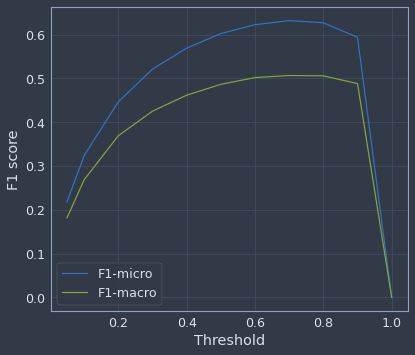

t_s: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1_micro: [0.21835780138967745, 0.3236328591550456, 0.4465887566563025, 0.5211939603758764, 0.5692189483530434, 0.6023701884616101, 0.6227167665528033, 0.6320217767879237, 0.6271917791135609, 0.5939802387343652, 0.0]
f1 macro: [0.18164493652805275, 0.2684966185170329, 0.3691111656393227, 0.4252931228138293, 0.46170253724455124, 0.4865466570145137, 0.5019670634330035, 0.5065800941732366, 0.5059681987539597, 0.48815103637790874, 0.0]
0.7


In [55]:
# predict probabilities, lr - new
y_pred_prob = clf.predict_proba(xval_tfidf)
print(y_pred_prob.shape)

threshold_opt = optimize_threshold_for_f1(yval, y_pred_prob)
print(threshold_opt)

## Check if there are empty predictions

In [56]:
def get_pred_zeros(y_pred):
    cnt = 0
    for pred in y_pred:
        if not np.any(pred):
            cnt += 1
    return cnt

In [58]:
# balanced
print(f"ypred number of zero predicitons: "
      f"{get_pred_zeros(y_pred)}/{len(y_pred)}")
# print(f"ypred forest number of zero predicitons:"
#     f" {get_pred_zeros(y_pred_dtc)}/{len(y_pred_dtc)}")

ypred number of zero predicitons: 416/7816
